_Version log: Branch of V19. Parameter scan accross number of pixels._

In [30]:
import sys, warnings
import numpy as np
import CS_functions as cs
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
from matplotlib import ticker as ticker, pyplot as plt
from scipy import fft as spfft, interpolate as spinter
from tqdm import tqdm
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':16})
#np.set_printoptions(threshold=sys.maxsize)

In [31]:
def interpolate(y, new_number_of_points):
    x = range(len(y))
    new_x = np.linspace(0, len(y) -1, new_number_of_points, endpoint= True)
    inter = spinter.interp1d(x, y, kind= "linear", bounds_error= False, fill_value= "extrapolate")
    return inter(new_x)

## TRAIN WITH NOISELESS INTERFEROGRAM

In [32]:
training_file_number = 15 # Use a noiseless version of the interferogram for good convergence
training_file_name = "1dmockanderrors{:d}".format(training_file_number)
file_type = ".csv"
total_point = 200
regularization_coeffient = 1e-3 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)

In [33]:
#LOOP INITIALISATION

unique_reduced_points = [8] #[4, 6, 8, 10, 12, 14, 16, 20, 25, 30, 35, 40, 50, 60, 80, 100]
repetitions = 2000
reduced_points = np.repeat(unique_reduced_points, repetitions)

dataset = cs.open_dataset(training_file_name, file_type)
best_scores = {"Simulated Annealing": np.array([]),
               "MCMC Metropolis": np.array([]),
               "Douglas Peucker": np.array([]),
               "Greedy": np.array([])}
best_configurations = {"Simulated Annealing": [],
               "MCMC Metropolis": [],
               "Douglas Peucker": [],
               "Greedy": []}

optlocs_file = "data\\" + training_file_name +"_randoptlocs.csv"

In [34]:
###################### THIS WILL TAKE A LONG TIME!!! #################

for reduced_point in tqdm(reduced_points):

    compression = total_point /dataset.shape[1]
    target = interpolate(dataset[0], total_point)
    uncertainties = interpolate(dataset[1], total_point)

    detectors, score = cs.simulated_annealing(reduced_point, target, uncertainties, regularization_coeffient, "random", cooling= 0.998, iterations= 10000)
    best_scores["Simulated Annealing"] = np.append(best_scores["Simulated Annealing"], score)
    best_configurations["Simulated Annealing"] += [detectors]
    cs.append_array_to_csv(detectors, optlocs_file)

    #detectors, score = cs.MCMC_metropolis(reduced_point, target, uncertainties, regularization_coeffient, "random", iterations= 20000)
    #best_scores["MCMC Metropolis"] = np.append(best_scores["MCMC Metropolis"], score)
    #best_configurations["MCMC Metropolis"] += [detectors]
    #cs.append_array_to_csv(detectors, optlocs_file)

    #detectors, score = cs.douglas_peucker(reduced_point, target, uncertainties, regularization_coeffient)
    #best_scores["Douglas Peucker"] = np.append(best_scores["Douglas Peucker"], score)
    #best_configurations["Douglas Peucker"] += [detectors]
    #cs.append_array_to_csv(detectors, optlocs_file)

    #detectors, score = cs.greedy(reduced_point, target, uncertainties, regularization_coeffient, "regular", iterations= 20)
    #best_scores["Greedy"] = np.append(best_scores["Greedy"], score)
    #best_configurations["Greedy"] += [detectors]
    #cs.append_array_to_csv(detectors, optlocs_file)

#np.split(best_configurations["Greedy"], np.cumsum(reduced_points)[:-1]) # shouldn't need this anymore

100%|██████████| 2000/2000 [60:20:00<00:00, 108.60s/it]   


In [35]:
best_configurations

{'Simulated Annealing': [array([ 11,  28,  30,  35,  66, 103, 151, 197]),
  array([ 25,  39, 121, 131, 153, 163, 165, 189]),
  array([  8,  31,  32,  33,  39,  85, 148, 181]),
  array([ 49,  95, 101, 116, 136, 138, 141, 147]),
  array([ 24,  47,  50,  71,  85, 106, 121, 175]),
  array([  3,  17,  34,  60,  92, 134, 154, 189]),
  array([ 18,  95, 101, 107, 110, 132, 142, 162]),
  array([ 50,  99, 106, 120, 125, 148, 156, 192]),
  array([ 22,  26,  59, 107, 120, 164, 173, 184]),
  array([ 37,  57,  69,  81,  86, 145, 167, 184]),
  array([ 85,  99, 106, 124, 143, 154, 161, 198]),
  array([ 11,  17,  25,  39, 114, 119, 177, 182]),
  array([ 12,  17,  23,  79,  83,  99, 105, 189]),
  array([ 10,  11,  26,  60, 128, 146, 167, 196]),
  array([  7,  27,  71,  93,  99, 141, 192, 193]),
  array([ 15,  38,  41,  92, 114, 124, 132, 196]),
  array([ 10,  71,  93,  99, 135, 143, 146, 179]),
  array([  0,  41,  73,  93, 100, 107, 117, 149]),
  array([ 16,  30,  60, 114, 126, 140, 169, 181]),
  array(

## TEST WITH NOISY INTERFEROGRAM

In [36]:
test_file_number = 17
test_file_name = "1dmockanderrors{:d}".format(test_file_number)
file_type = ".csv"
target, uncertainties = cs.open_dataset(test_file_name, file_type)

for method, scores, configurations in list(zip(best_scores.keys(), best_scores.values(), best_configurations.values())): # Re-evaluate all of the scores for a noisy version of the interferogram.
    #print(best_configurations)
    #best_configurations[method] = np.split(configurations, np.cumsum(reduced_points)[:-1])
    for n, score, configuration in zip(range(len(scores)), scores, configurations):
        #best_configurations[method][n] = configuration.astype(int)
        #print(configuration.dtype)
        best_scores[method][n] = cs.evaluate_score(configuration, target, uncertainties, regularization_coeffient)

In [37]:
mean_score = {method: np.mean(np.reshape(best_score, (len(unique_reduced_points), repetitions)), axis= 1) for method, best_score in best_scores.items() if len(best_score) > 0}
std_score = {method: np.std(np.reshape(best_score, (len(unique_reduced_points), repetitions)), axis= 1) for method, best_score in best_scores.items() if len(best_score) > 0}
max_score = {method: np.max(np.reshape(best_score, (len(unique_reduced_points), repetitions)), axis= 1) for method, best_score in best_scores.items() if len(best_score) > 0}
min_score = {method: np.min(np.reshape(best_score, (len(unique_reduced_points), repetitions)), axis= 1) for method, best_score in best_scores.items() if len(best_score) > 0}

In [38]:
flatline = np.zeros_like(target)
flatline_score = np.linalg.norm((target -flatline) /uncertainties) #This is the chi-squared

noiseless, _ = cs.open_dataset(training_file_name, file_type)
noiseless_score = np.linalg.norm((target -noiseless) /uncertainties) #This is the chi-squared

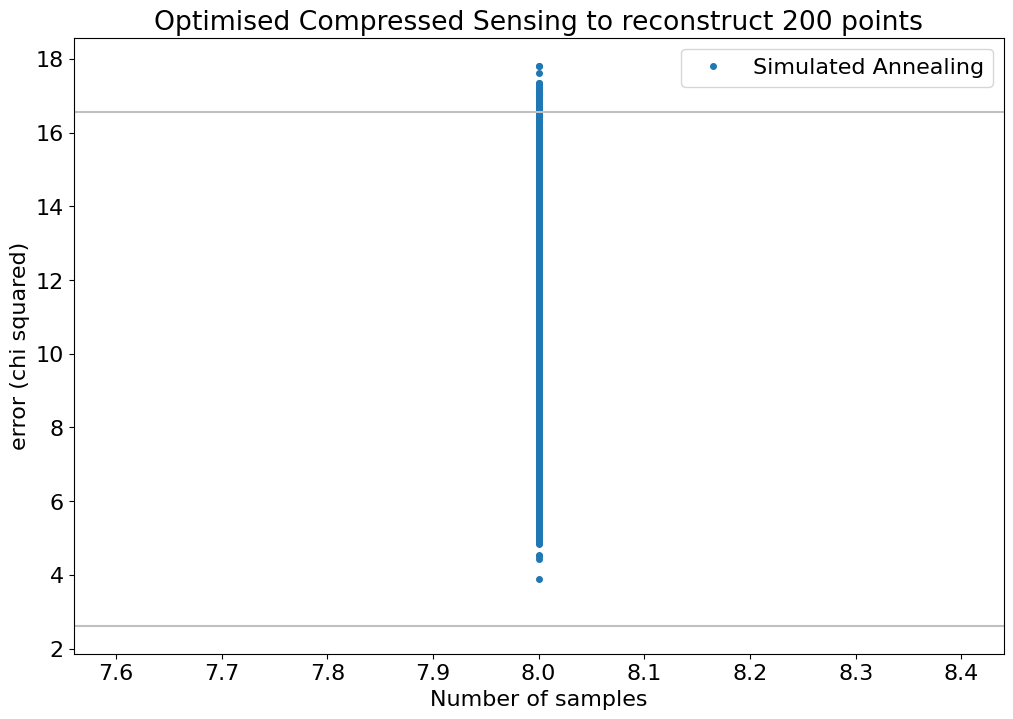

In [39]:
fig, axs = plt.subplots(figsize= (12,8))

axs.plot(reduced_points, best_scores["Simulated Annealing"], linestyle= "None", marker= ".", markersize= 8, label= "Simulated Annealing")
#axs.plot(reduced_points, best_scores["MCMC Metropolis"], linestyle= "None", marker= ".", markersize= 8, label= "MCMC Metropolis")

axs.hlines([flatline_score, noiseless_score], 0, 1, colors= "silver", transform= axs.get_yaxis_transform())
axs.annotate("Flat line", (10,flatline_score+0.1), color= "dimgray")
axs.annotate("Noiseless solution", (10,noiseless_score+0.1), color= "dimgray")

axs.set(xlabel= "Number of samples",
        ylabel= "error (chi squared)",
        title= "Optimised Compressed Sensing to reconstruct {0:d} points".format(total_point))

#axs.grid(True)
axs.legend()

plt.show()

KeyError: 'MCMC Metropolis'

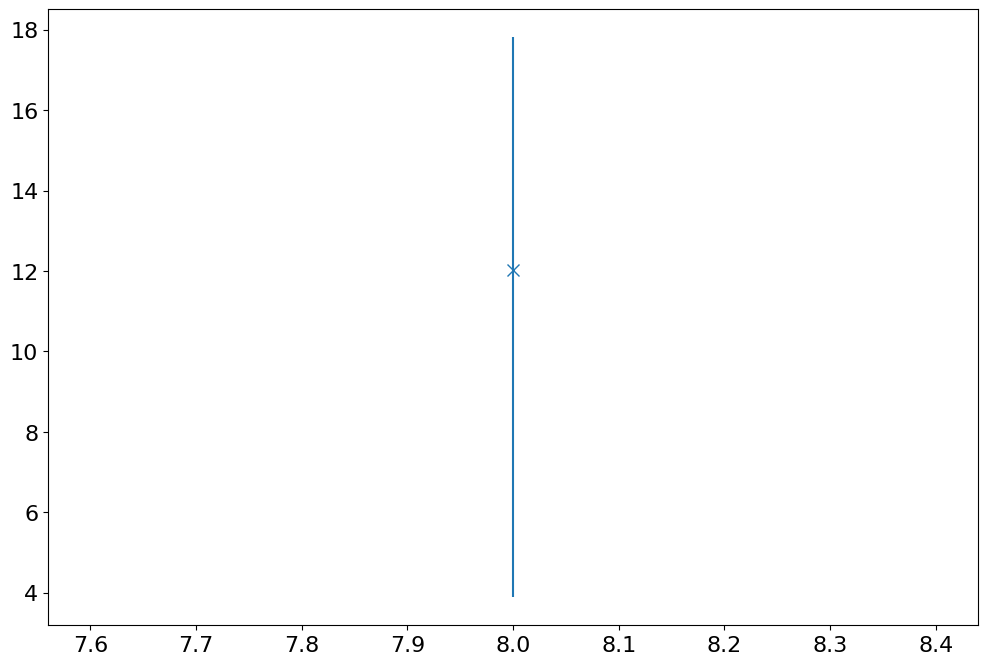

In [40]:
markers= ["x", "o", "^", "s"]

fig, axs = plt.subplots(figsize= (12,8))

for method, marker in zip(best_scores.keys(), markers):
        axs.errorbar(unique_reduced_points, mean_score[method],
                     yerr= (np.abs(mean_score[method] -min_score[method]), np.abs(max_score[method] -mean_score[method])), # can contain negative values due to floating point errors
                     linestyle= "None", marker= marker, markersize= 8, label= method)

#axs.hlines([flatline_score, noiseless_score], 0, 1, colors= "silver", transform= axs.get_yaxis_transform())
#axs.annotate("Flat line", (10,flatline_score+0.1), color= "dimgray")
#axs.annotate("Noiseless solution", (10,noiseless_score+0.1), color= "dimgray")


axs.set(xlabel= "Number of samples",
        ylabel= "error (chi squared)",
        title= "Optimised Compressed Sensing to reconstruct {0:d} points".format(total_point))


axs.grid(True)
axs.legend()

plt.show()

## PROBIBLITY DISTROBUTION FOR WHERE THE SENSORS END UP AFTER SA OPTIMISATION

In [41]:
optlocs_file = "data\\" + training_file_name +"_randoptlocs.csv"

sensor_distrobution = cs.open_csv(optlocs_file, number_of_columns= 8)
target, uncertainties = cs.open_dataset(training_file_name, file_type)


In [74]:
frequent_locs = np.array(np.unique(sensor_distrobution, return_counts=True)).T
sensor_distrobution = sensor_distrobution[~np.isnan(sensor_distrobution)]
#frequent_locs = frequent_locs[:-1] #remove nans
frequent_locs = frequent_locs[frequent_locs[:, 1].argsort()[::-1]]
#frequent_locs = [frequent_locs[frequent_locs[:,0].tolist().index(n),1] if n in frequent_locs[:,0] else np.nan for n in range(total_point)] # Put it back in order of sensor index.
#frequent_locs = np.array(frequent_locs)
print("Detector locations: Occurrences")
print(frequent_locs[:, :])

Detector locations: Occurrences
[[106 717]
 [ 92 675]
 [ 93 626]
 [ 99 595]
 [100 509]
 [ 86 464]
 [114 450]
 [ 85 439]
 [  3 437]
 [121 419]
 [195 415]
 [115 411]
 [196 410]
 [107 399]
 [  4 393]
 [ 11 369]
 [ 78 368]
 [ 79 367]
 [188 362]
 [ 18 358]
 [181 329]
 [ 46 324]
 [ 10 323]
 [ 25 310]
 [ 32 310]
 [146 310]
 [113 309]
 [189 308]
 [ 39 301]
 [174 295]
 [ 60 291]
 [ 67 288]
 [168 284]
 [160 283]
 [122 278]
 [153 274]
 [128 274]
 [ 31 274]
 [126 270]
 [ 87 270]
 [167 269]
 [120 269]
 [139 262]
 [ 47 261]
 [ 84 256]
 [ 71 254]
 [127 251]
 [152 248]
 [141 244]
 [138 242]
 [175 242]
 [ 50 241]
 [ 68 238]
 [131 237]
 [ 53 236]
 [149 233]
 [182 230]
 [145 225]
 [187 221]
 [132 220]
 [ 42 216]
 [ 27 211]
 [ 73 211]
 [ 19 209]
 [ 61 208]
 [ 17 207]
 [ 38 206]
 [ 12 205]
 [161 204]
 [169 204]
 [137 204]
 [173 203]
 [172 203]
 [ 62 202]
 [157 201]
 [ 26 199]
 [ 43 198]
 [180 196]
 [ 44 195]
 [116 195]
 [194 195]
 [ 16 192]
 [ 72 192]
 [159 191]
 [166 190]
 [ 48 190]
 [143 189]
 [156 189]


In [43]:
frequent_locs = [frequent_locs[frequent_locs[:,0].tolist().index(n),1] if n in frequent_locs[:,0] else 0 for n in range(total_point)] # Put it back in order of sensor index.
frequent_locs = np.array(frequent_locs)

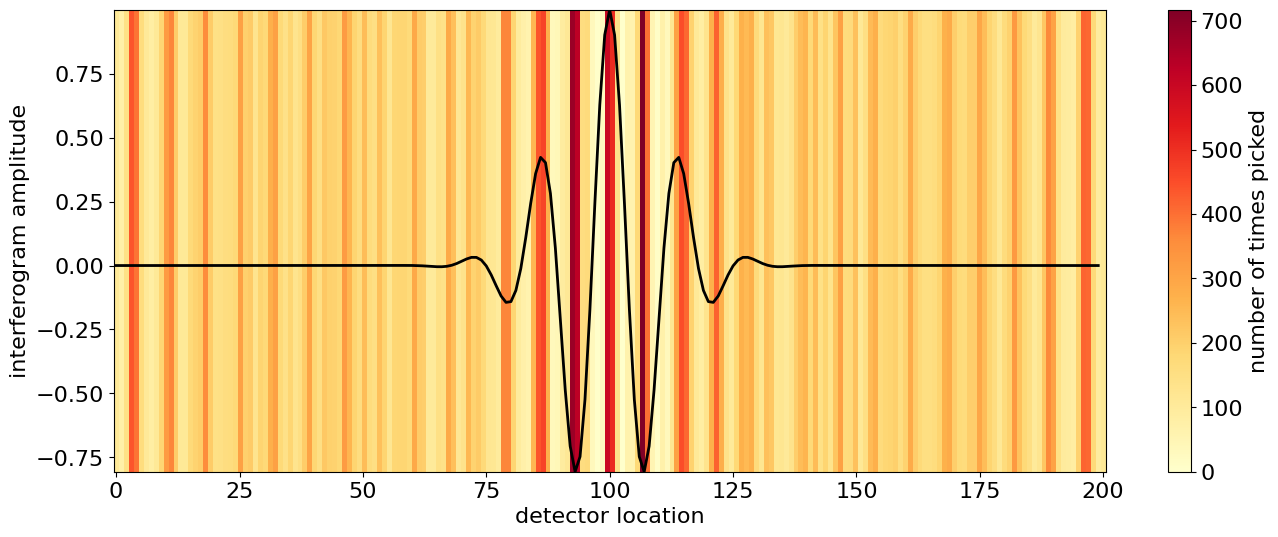

In [44]:
fig, axs = plt.subplots(figsize= (16,6))

axs.plot(target, color= "k", linewidth= 2, label= "interferogram")

im = plt.imshow([frequent_locs], aspect= "auto", extent= (-0.5, total_point +0.5, min(target), max(target)), cmap= "YlOrRd")#, norm= "log")
plt.colorbar(im, label= "number of times picked")

axs.set(xlabel= "detector location", ylabel= "interferogram amplitude")
plt.show()

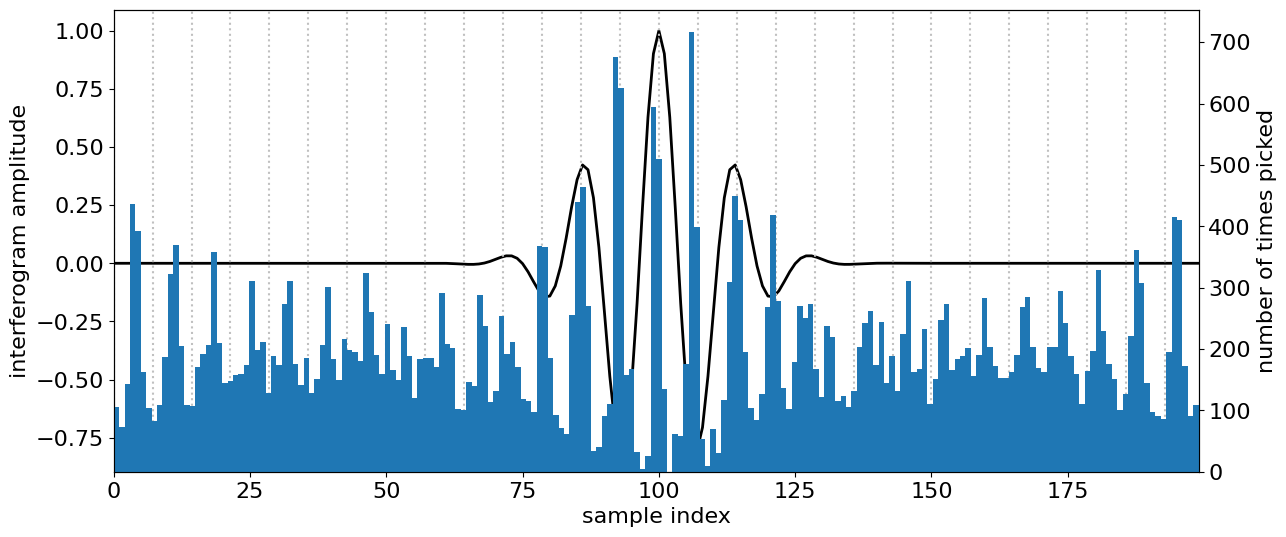

In [45]:
bins = int(total_point//1)

fig, axs = plt.subplots(figsize= (14,6))

axs.plot(target, color= "k", linewidth= 2, label= "interferogram")
axs.set(xlabel= "sample index", ylabel= "interferogram amplitude", xlim= (0, total_point-1))
axs.vlines(np.arange(0, 30) /0.14, ymin= 0, ymax= 1, colors= "silver", linestyles= ":",transform= axs.get_xaxis_transform()) # 0.14 pixels^-1 is the nyquist spatial frequency for the central wavelength (3 THz or 0.7 pixels^-1)

twinax = axs.twinx()
#twinax.plot(frequent_locs, linestyle= "None", marker= "x", markersize= 8)
twinax.hist(sensor_distrobution, bins= bins)
twinax.set(ylabel= "number of times picked")

plt.show()

In [46]:
np.round(np.arange(0, 29) /0.14).astype(int)

array([  0,   7,  14,  21,  29,  36,  43,  50,  57,  64,  71,  79,  86,
        93, 100, 107, 114, 121, 129, 136, 143, 150, 157, 164, 171, 179,
       186, 193, 200])

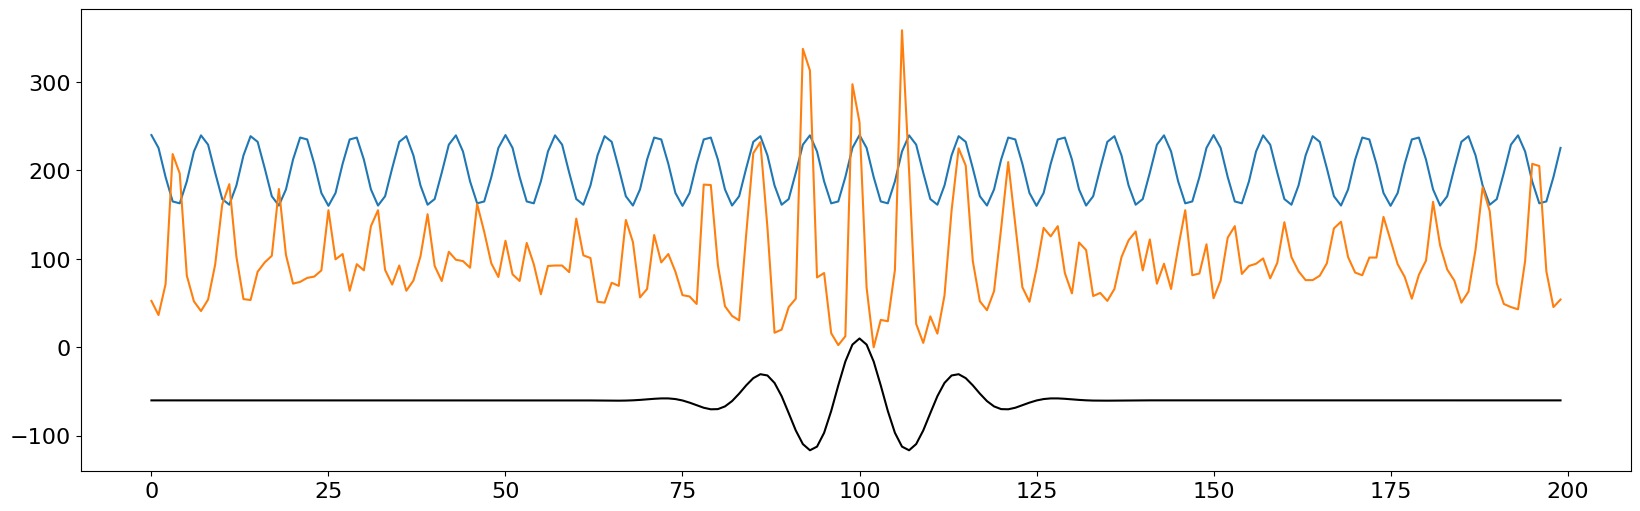

In [47]:
dirac_delta = np.zeros(101)
dirac_delta[28] = 20.
sinosoid = np.fft.irfft(dirac_delta, norm= "forward")

plt.figure(figsize= (20, 6))
plt.plot(target*70 -60, color= "k")
plt.plot(sinosoid +200)
plt.plot(frequent_locs *0.5)
plt.show()

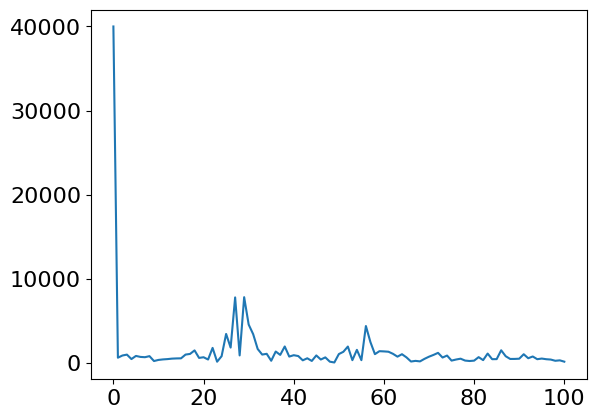

[ 0 29 27]


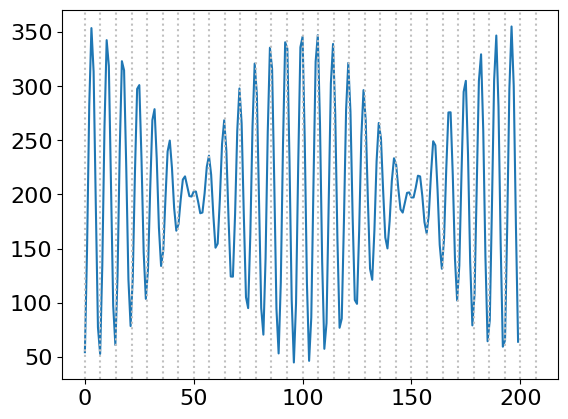

In [73]:
n = 3

test = np.fft.rfft(frequent_locs)

plt.plot(np.abs(test))
plt.show()

sig_freqs = np.argsort(np.abs(test))[::-1]
print(sig_freqs[:n])

test2 = np.zeros_like(test)
test2[sig_freqs[:n]] = test[sig_freqs[:n]]
test2 = np.fft.irfft(test2)

plt.plot(test2)
plt.vlines(np.arange(0, 30) /0.14, ymin= 0, ymax= 1, colors= "silver", linestyles= ":",transform= plt.gca().get_xaxis_transform()) # 0.14 pixels^-1 is the nyquist spatial frequency for the central wavelength (3 THz or 0.7 pixels^-1)
plt.show()